# Train JetTagger 

We will train a jet tagger using `Keras` + `TensorFlow` 

In [1]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf
tf.random.set_seed(seed)
import os

## Fetch the jet tagging dataset from Open ML

In [2]:
data = fetch_openml('hls4ml_lhc_jets_hlf')
X, y = data['data'], data['target']

### Let's print some information about the dataset
Print the feature names and the dataset shape

In [3]:
print(data['feature_names'])
print(X.shape, y.shape)
print(X[:5])
print(y[:5])

['zlogz', 'c1_b0_mmdt', 'c1_b1_mmdt', 'c1_b2_mmdt', 'c2_b1_mmdt', 'c2_b2_mmdt', 'd2_b1_mmdt', 'd2_b2_mmdt', 'd2_a1_b1_mmdt', 'd2_a1_b2_mmdt', 'm2_b1_mmdt', 'm2_b2_mmdt', 'n2_b1_mmdt', 'n2_b2_mmdt', 'mass_mmdt', 'multiplicity']
(830000, 16) (830000,)
      zlogz  c1_b0_mmdt  c1_b1_mmdt  c1_b2_mmdt  c2_b1_mmdt  c2_b2_mmdt  \
0 -2.935125    0.383155    0.005126    0.000084    0.009070    0.000179   
1 -1.927335    0.270699    0.001585    0.000011    0.003232    0.000029   
2 -3.112147    0.458171    0.097914    0.028588    0.124278    0.038487   
3 -2.666515    0.437068    0.049122    0.007978    0.047477    0.004802   
4 -2.484843    0.428981    0.041786    0.006110    0.023066    0.001123   

   d2_b1_mmdt  d2_b2_mmdt  d2_a1_b1_mmdt  d2_a1_b2_mmdt  m2_b1_mmdt  \
0    1.769445    2.123898       1.769445       0.308185    0.135687   
1    2.038834    2.563099       2.038834       0.211886    0.063729   
2    1.269254    1.346238       1.269254       0.246488    0.115636   
3    0.966505  

As you saw above, the y target is an array of strings, e.g. ['g', 'w',...] etc. We need to make this a "One Hot" encoding for the training. Then, split the dataset into training and validation sets

In [4]:
le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y, 5)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(y[:5])

[[1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]]


In [5]:
scaler = StandardScaler()
X_train_val = scaler.fit_transform(X_train_val)
X_test = scaler.transform(X_test)

In [6]:
np.save('X_train_val.npy', X_train_val)
np.save('X_test.npy', X_test)
np.save('y_train_val.npy', y_train_val)
np.save('y_test.npy', y_test)
np.save('classes.npy', le.classes_)

## Now construct a model
We'll use 3 hidden layers with 64, then 32, then 32 neurons. Each layer will use `relu` activation.
Add an output layer with 5 neurons (one for each class), then finish with Softmax activation.

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks

In [8]:
model = Sequential()
model.add(Dense(64, input_shape=(16,), name='fc1', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu1'))
model.add(Dense(32, name='fc2', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu2'))
model.add(Dense(32, name='fc3', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu3'))
model.add(Dense(5, name='output', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='softmax', name='softmax'))

2025-08-07 23:12:30.427320: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-07 23:12:31.552079: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 37068 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (Dense)                 (None, 64)                1088      
                                                                 
 relu1 (Activation)          (None, 64)                0         
                                                                 
 fc2 (Dense)                 (None, 32)                2080      
                                                                 
 relu2 (Activation)          (None, 32)                0         
                                                                 
 fc3 (Dense)                 (None, 32)                1056      
                                                                 
 relu3 (Activation)          (None, 32)                0         
                                                                 
 output (Dense)              (None, 5)                 1

## Train the model
We'll use Adam optimizer with categorical crossentropy loss.
The callbacks will decay the learning rate and save the model into a directory **'baseline_model'**
The model isn't very complex, so this should just take a few minutes even on the CPU.
If you've restarted the notebook kernel after training once, set `train = False` to load the trained model.

In [10]:
train = True
if train:
    adam = Adam(lr=0.0001)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(stop_patience = 1000,
                              lr_factor = 0.5,
                              lr_patience = 10,
                              lr_epsilon = 0.000001,
                              lr_cooldown = 2,
                              lr_minimum = 0.0000001,
                              outputDir = 'baseline_model')
    model.fit(X_train_val, y_train_val, batch_size=1024,
              epochs=30, validation_split=0.25, shuffle=True,
              callbacks = callbacks.callbacks)
else:
    from tensorflow.keras.models import load_model
    model = load_model('baseline_model/KERAS_check_best_model.h5')

/global/common/software/nersc9/tensorflow/2.9.0/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/30
 31/487 [>.............................] - ETA: 0s - loss: 1.6227 - accuracy: 0.2912   

2025-08-07 23:12:37.052541: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


468/487 [===========================>..] - ETA: 0s - loss: 1.3370 - accuracy: 0.5116
***callbacks***
saving losses to baseline_model/losses.log

Epoch 1: val_loss improved from inf to 1.12517, saving model to baseline_model/KERAS_check_best_model.h5

Epoch 1: val_loss improved from inf to 1.12517, saving model to baseline_model/KERAS_check_best_model_weights.h5

Epoch 1: saving model to baseline_model/KERAS_check_model_last.h5

Epoch 1: saving model to baseline_model/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 6s 3ms/step - loss: 1.3291 - accuracy: 0.5162 - val_loss: 1.1252 - val_accuracy: 0.6363 - lr: 1.0000e-04
Epoch 2/30
483/487 [============================>.] - ETA: 0s - loss: 1.0554 - accuracy: 0.6666
***callbacks***
saving losses to baseline_model/losses.log

Epoch 2: val_loss improved from 1.12517 to 1.00706, saving model to baseline_model/KERAS_check_best_model.h5

Epoch 2: val_loss improved from 1.12517 to 1.00706, saving

## Check performance
Check the accuracy and make a ROC curve

5188/5188 [==============================] - 3s 656us/step
Accuracy: 0.7503734939759036


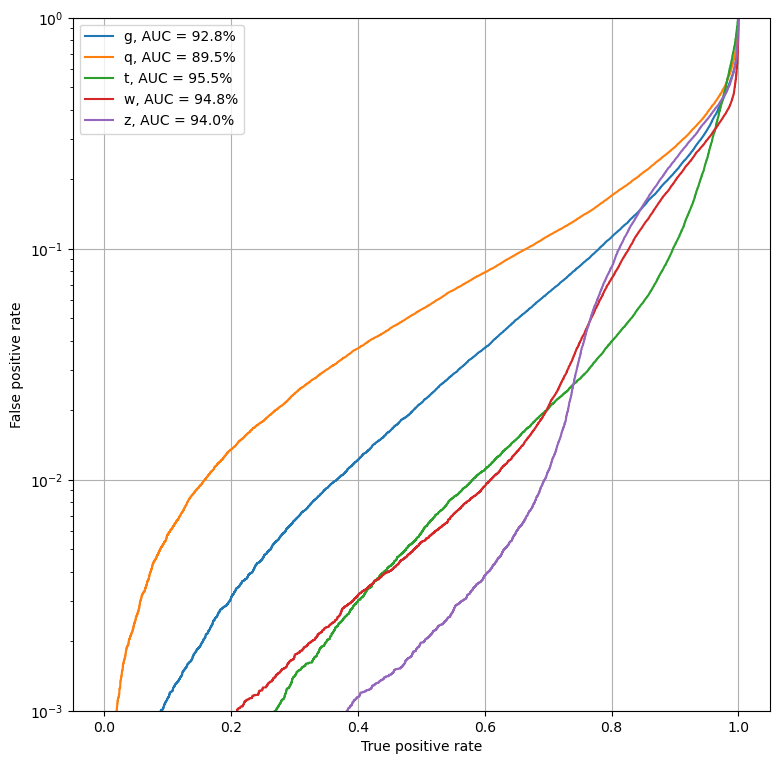

In [11]:
import plotting
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
y_keras = model.predict(X_test)
print("Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
plt.figure(figsize=(9,9))
_ = plotting.make_roc(y_test, y_keras, le.classes_)